# 1	DistilBERT o RoBERTa-base fine-tuned

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch, platform
print("CUDA disponible:", torch.cuda.is_available())
print("GPUs detectadas:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU 0:", torch.cuda.get_device_name(0))
    print("CUDA ver:", torch.version.cuda)
    print("cuDNN ver:", torch.backends.cudnn.version())


CUDA disponible: True
GPUs detectadas: 1
GPU 0: NVIDIA GeForce RTX 3050 6GB Laptop GPU
CUDA ver: 12.1
cuDNN ver: 90100


En este bloque se importa librerías básicas, define las rutas del proyecto y del CSV, indica qué columnas contienen el texto (Resume_str) y la etiqueta (Category), y configura el modelo base que se descargará del Hugging Face Hub (distilbert-base-uncased) junto con la carpeta donde se guardarán resultados y checkpoints.

In [3]:
import os, numpy as np, pandas as pd

# Ruta a tu proyecto y dataset (Windows)
PROJECT_DIR = r"C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2"
DATA_PATH   = rf"{PROJECT_DIR}\jarvis-calling-hiring-contest\Resume\Resume.csv"

# Columnas del dataset
TEXT_COL  = "Resume_str"
LABEL_COL = "Category"

# Modelo desde el Hub (no local)
MODEL_NAME = "distilbert-base-uncased"
OUTPUT_DIR = rf"{PROJECT_DIR}\results_distilbert"

# Tokenización
MAX_LEN   = 512  # sube a 512 si tienes VRAM
SEED      = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)


Este bloque carga el CSV, limpia filas sin texto o etiqueta y divide el dataset en tres partes: entrenamiento (80%), validación (10%) y prueba (10%). La división es estratificada por Category, es decir, mantiene la misma proporción de clases en cada split para evitar sesgos y hacer comparables las métricas.

In [4]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)

train_df, temp_df = train_test_split(
    df, test_size=0.20, random_state=SEED, stratify=df[LABEL_COL]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=SEED, stratify=temp_df[LABEL_COL]
)

for name, d in [("train",train_df),("val",val_df),("test",test_df)]:
    print(name, d.shape)


train (1987, 4)
val (248, 4)
test (249, 4)


Este bloque toma el conjunto de clases del dataset completo, lo ordena y construye label2id (de nombre de clase a índice) y id2label (de índice a nombre), junto con NUM_CLASSES.

In [5]:
# Mapeo consistente en todos los splits
all_labels = sorted(df[LABEL_COL].unique())
label2id = {lbl:i for i, lbl in enumerate(all_labels)}
id2label = {i:lbl for lbl,i in label2id.items()}
NUM_CLASSES = len(label2id)

print("NUM_CLASSES =", NUM_CLASSES)
print("Ejemplo mapeo:", list(label2id.items())[:5])


NUM_CLASSES = 24
Ejemplo mapeo: [('ACCOUNTANT', 0), ('ADVOCATE', 1), ('AGRICULTURE', 2), ('APPAREL', 3), ('ARTS', 4)]


Aquí se prepara la tokenización con el tokenizer de Hugging Face para MODEL_NAME y define dos utilidades: tokenize_texts recibe una lista de textos y los convierte en secuencias de ids con su attention mask, aplicando padding/truncation a max_len para que todos tengan la misma longitud; devuelve numpy arrays (int32 para input_ids y int8 para la máscara) listos para crear datasets o tensores de PyTorch. labels_to_ids transforma las etiquetas de texto a sus índices numéricos usando el mapeo label2id, de modo que el modelo trabaje con clases enteras coherentes con lo definido antes.

In [6]:
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_texts(texts, max_len=256):
    enc = tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_attention_mask=True,
        return_tensors=None  # devolvemos listas; luego convertimos a np
    )
    # conv a numpy arrays
    input_ids = np.array(enc["input_ids"], dtype=np.int32)
    attention_mask = np.array(enc["attention_mask"], dtype=np.int8)
    return input_ids, attention_mask

def labels_to_ids(labels):
    return np.array([label2id[l] for l in labels], dtype=np.int64)


Este bloque tokeniza y etiqueta cada split por separado usando el mismo tokenizer y MAX_LEN: para train/val/test genera input_ids (ids de tokens), attention_mask (1 donde hay token real, 0 en padding) y labels (índices de clase), todo en numpy. Empaqueta cada split en un diccionario con el formato que espera Hugging Face ({"input_ids", "attention_mask", "labels"}) y muestra las dimensiones para verificar que el número de filas coincide con cada split y que todas las secuencias quedaron del mismo largo

In [7]:
# Train
tr_input_ids, tr_att = tokenize_texts(train_df[TEXT_COL], max_len=MAX_LEN)
tr_labels = labels_to_ids(train_df[LABEL_COL])

# Val
va_input_ids, va_att = tokenize_texts(val_df[TEXT_COL], max_len=MAX_LEN)
va_labels = labels_to_ids(val_df[LABEL_COL])

# Test
te_input_ids, te_att = tokenize_texts(test_df[TEXT_COL], max_len=MAX_LEN)
te_labels = labels_to_ids(test_df[LABEL_COL])

# Estructuras dict "como si" vinieran de .npz
train_data = {
    "input_ids": tr_input_ids,
    "attention_mask": tr_att,
    "labels": tr_labels
}
val_data = {
    "input_ids": va_input_ids,
    "attention_mask": va_att,
    "labels": va_labels
}
test_data = {
    "input_ids": te_input_ids,
    "attention_mask": te_att,
    "labels": te_labels
}

for name, d in [("train",train_data),("val",val_data),("test",test_data)]:
    print(name, {k: v.shape for k,v in d.items()})


train {'input_ids': (1987, 512), 'attention_mask': (1987, 512), 'labels': (1987,)}
val {'input_ids': (248, 512), 'attention_mask': (248, 512), 'labels': (248,)}
test {'input_ids': (249, 512), 'attention_mask': (249, 512), 'labels': (249,)}


In [8]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_data)
val_dataset   = Dataset.from_dict(val_data)
test_dataset_hf = Dataset.from_dict(test_data)

train_dataset, val_dataset, test_dataset_hf


(Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 1987
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 248
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 249
 }))

In [9]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [10]:
import numpy as np, torch
from transformers import set_seed
from sklearn.utils.class_weight import compute_class_weight

set_seed(42)

# extrae labels de train para ponderar la loss si hay desbalance
y_train = np.array(train_dataset["labels"])
classes = np.array(sorted(np.unique(y_train)))
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = torch.tensor(cw, dtype=torch.float32)
print("Class weights shape:", class_weights.shape)


Class weights shape: torch.Size([24])


Este bloque define la función de métricas que usará el Trainer: a partir de los logits predichos y las etiquetas verdaderas, obtiene las clases con argmax y calcula accuracy, precision, recall y F1 con promedio macro (cada clase pesa igual, útil con desbalance). Además, cuando es posible, transforma los logits en probabilidades con softmax para computar un ROC-AUC macro (one-vs-rest) en problemas multiclase. El resultado se devuelve como un diccionario que el Trainer registrará en validación/evaluación

In [11]:
import numpy as np, torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

num_labels = NUM_CLASSES

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    out = {
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
    }

    # ROC-AUC macro OVR (requiere probabilidades)
    try:
        probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
        if num_labels >= 2:
            out["roc_auc_macro_ovr"] = float(
                roc_auc_score(labels, probs, multi_class="ovr", average="macro")
            )
    except Exception:
        pass

    return out


Este bloque descarga desde el Hub el modelo DistilBERT ya preparado para clasificación de secuencias, configurándole el número de clases y el mapeo id↔label, y luego lo envía al dispositivo disponible (GPu).

In [12]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id,
    torch_dtype=torch.float32,   # AMP lo gestiona durante el train
)
model.to(device)

print("Modelo:", MODEL_NAME)
print("Dispositivo:", next(model.parameters()).device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo: distilbert-base-uncased
Dispositivo: cuda:0
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


Este bloque construye de forma compatible con distintas versiones de transformers los TrainingArguments para entrenar DistilBERT. 

Detecta dinámicamente qué nombres de parámetros se admiten y los alinea a epoch para que evaluación y guardado ocurran al final de cada época, habilitando load_best_model_at_end=True y seleccionando f1_macro como métrica para escoger el mejor checkpoint. 

También fija hiperparámetros estándar (batch, learning_rate, épocas, weight_decay, warmup_ratio)

In [13]:
# Bloque E (compat v2): TrainingArguments con alias y estrategias alineadas
import inspect, transformers
from transformers import TrainingArguments, Trainer
import torch

print("transformers version:", transformers.__version__)

BATCH = 16
LR = 2e-5
EPOCHS = 10
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

def make_training_args(output_dir, fp16_flag):
    params = set(inspect.signature(TrainingArguments.__init__).parameters.keys())
    kw = {
        "output_dir": output_dir,
        "per_device_train_batch_size": BATCH,
        "per_device_eval_batch_size": BATCH,
        "learning_rate": LR,
        "num_train_epochs": EPOCHS,
        "weight_decay": WEIGHT_DECAY,
        "logging_steps": 50,
    }

    # Detecta nombres soportados
    eval_key = "evaluation_strategy" if "evaluation_strategy" in params else ("eval_strategy" if "eval_strategy" in params else None)
    save_key = "save_strategy" if "save_strategy" in params else None

    if eval_key and save_key:
        kw[eval_key] = "epoch"
        kw[save_key] = "epoch"
        if "load_best_model_at_end" in params:
            kw["load_best_model_at_end"] = True
        if "metric_for_best_model" in params:
            kw["metric_for_best_model"] = "f1_macro"
        if "greater_is_better" in params:
            kw["greater_is_better"] = True
    else:
        # Fallback si tu versión no tiene esas claves
        if "do_eval" in params: kw["do_eval"] = True
        if "eval_steps" in params: kw["eval_steps"] = 500
        if "save_steps" in params: kw["save_steps"] = 500
        if "load_best_model_at_end" in params: kw["load_best_model_at_end"] = False

    if "warmup_ratio" in params: kw["warmup_ratio"] = WARMUP_RATIO
    if "report_to" in params: kw["report_to"] = "none"
    if "fp16" in params: kw["fp16"] = fp16_flag
    if "save_total_limit" in params: kw["save_total_limit"] = 1

    return TrainingArguments(**kw)

args = make_training_args(OUTPUT_DIR, torch.cuda.is_available())

# (opcional) Verifica que quedaron alineadas
print("eval_strategy:", getattr(args, "evaluation_strategy", getattr(args, "eval_strategy", None)))
print("save_strategy:", getattr(args, "save_strategy", None))
print("load_best_model_at_end:", getattr(args, "load_best_model_at_end", None))


transformers version: 4.57.1
eval_strategy: IntervalStrategy.EPOCH
save_strategy: SaveStrategy.EPOCH
load_best_model_at_end: True


Este bloque crea un Trainer personalizado que aplica pesos por clase para combatir el desbalance: WeightedTrainer sobreescribe compute_loss y calcula la pérdida con CrossEntropyLoss(weight=class_weights), de modo que las clases minoritarias cuenten más. 

Luego instancia el entrenador con el modelo, los TrainingArguments ya definidos, los datasets de train/val, el tokenizer, un data collator simple (padding fijo), y la función compute_metrics que reporta f1_macro. También añade EarlyStopping con paciencia 2 épocas.

In [14]:
from transformers import Trainer, EarlyStoppingCallback, default_data_collator
import torch

# Versión compatible con transformers>=4.57.* (acepta num_items_in_batch)
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        if self.class_weights is not None:
            cw = self.class_weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=cw)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=args,                               # tus TrainingArguments ya creados
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=default_data_collator,     # tenemos padding fijo, OK
    compute_metrics=compute_metrics,         # devuelve 'f1_macro'
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    class_weights=class_weights,
)



In [15]:
train_result = trainer.train()
print(train_result)
print("Best checkpoint:", trainer.state.best_model_checkpoint)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Roc Auc Macro Ovr
1,3.146900,2.809163,0.629032,0.576692,0.575460,0.541048,0.901552
2,1.828000,1.567298,0.766129,0.684727,0.702309,0.667718,0.967048
3,1.169100,1.031762,0.830645,0.797376,0.789547,0.781580,0.979823
4,0.817000,0.837271,0.850806,0.841550,0.808216,0.814003,0.981819
5,0.704100,0.726933,0.850806,0.845016,0.824351,0.827304,0.984879
6,0.478000,0.703897,0.866935,0.852744,0.832918,0.835941,0.978791
7,0.439500,0.624635,0.870968,0.865795,0.842641,0.846846,0.984280
8,0.350500,0.642763,0.862903,0.866592,0.842009,0.847268,0.984795
9,0.295800,0.679395,0.854839,0.851443,0.827426,0.832485,0.980260
10,0.257600,0.680378,0.854839,0.852123,0.827426,0.833061,0.979840


TrainOutput(global_step=1250, training_loss=0.9972656394958496, metrics={'train_runtime': 411.3481, 'train_samples_per_second': 48.305, 'train_steps_per_second': 3.039, 'total_flos': 2633159896842240.0, 'train_loss': 0.9972656394958496, 'epoch': 10.0})
Best checkpoint: C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2\results_distilbert\checkpoint-1000


In [16]:
from sklearn.metrics import classification_report
import pandas as pd, numpy as np, torch

print("== Eval en validación ==")
metrics_val = trainer.evaluate(val_dataset)
display(pd.Series(metrics_val))

print("\n== Eval en test ==")
pred_test = trainer.predict(test_dataset_hf)
y_true = pred_test.label_ids
y_prob = torch.softmax(torch.tensor(pred_test.predictions), dim=1).numpy()
y_pred = y_prob.argmax(axis=1)



== Eval en validación ==


eval_loss                    0.642763
eval_accuracy                0.862903
eval_precision_macro         0.866592
eval_recall_macro            0.842009
eval_f1_macro                0.847268
eval_roc_auc_macro_ovr       0.984795
eval_runtime                 1.457500
eval_samples_per_second    170.160000
eval_steps_per_second       10.978000
epoch                       10.000000
dtype: float64


== Eval en test ==


In [17]:
print("\n== Eval en test ==")

rep = classification_report(
    y_true, y_pred,
    target_names=[id2label[i] for i in range(len(id2label))],
    digits=4, output_dict=True
)
df_rep = pd.DataFrame(rep).transpose()
display(df_rep)


== Eval en test ==


,precision,recall,f1-score,support
ACCOUNTANT,1.000000,1.000000,1.000000,12.000000
ADVOCATE,0.909091,0.833333,0.869565,12.000000
AGRICULTURE,1.000000,1.000000,1.000000,6.000000
APPAREL,0.583333,0.777778,0.666667,9.000000
ARTS,0.714286,0.454545,0.555556,11.000000
AUTOMOBILE,0.400000,0.666667,0.500000,3.000000
AVIATION,0.923077,1.000000,0.960000,12.000000
BANKING,1.000000,0.666667,0.800000,12.000000
BPO,0.200000,0.500000,0.285714,2.000000
BUSINESS-DEVELOPMENT,1.000000,1.000000,1.000000,12.000000


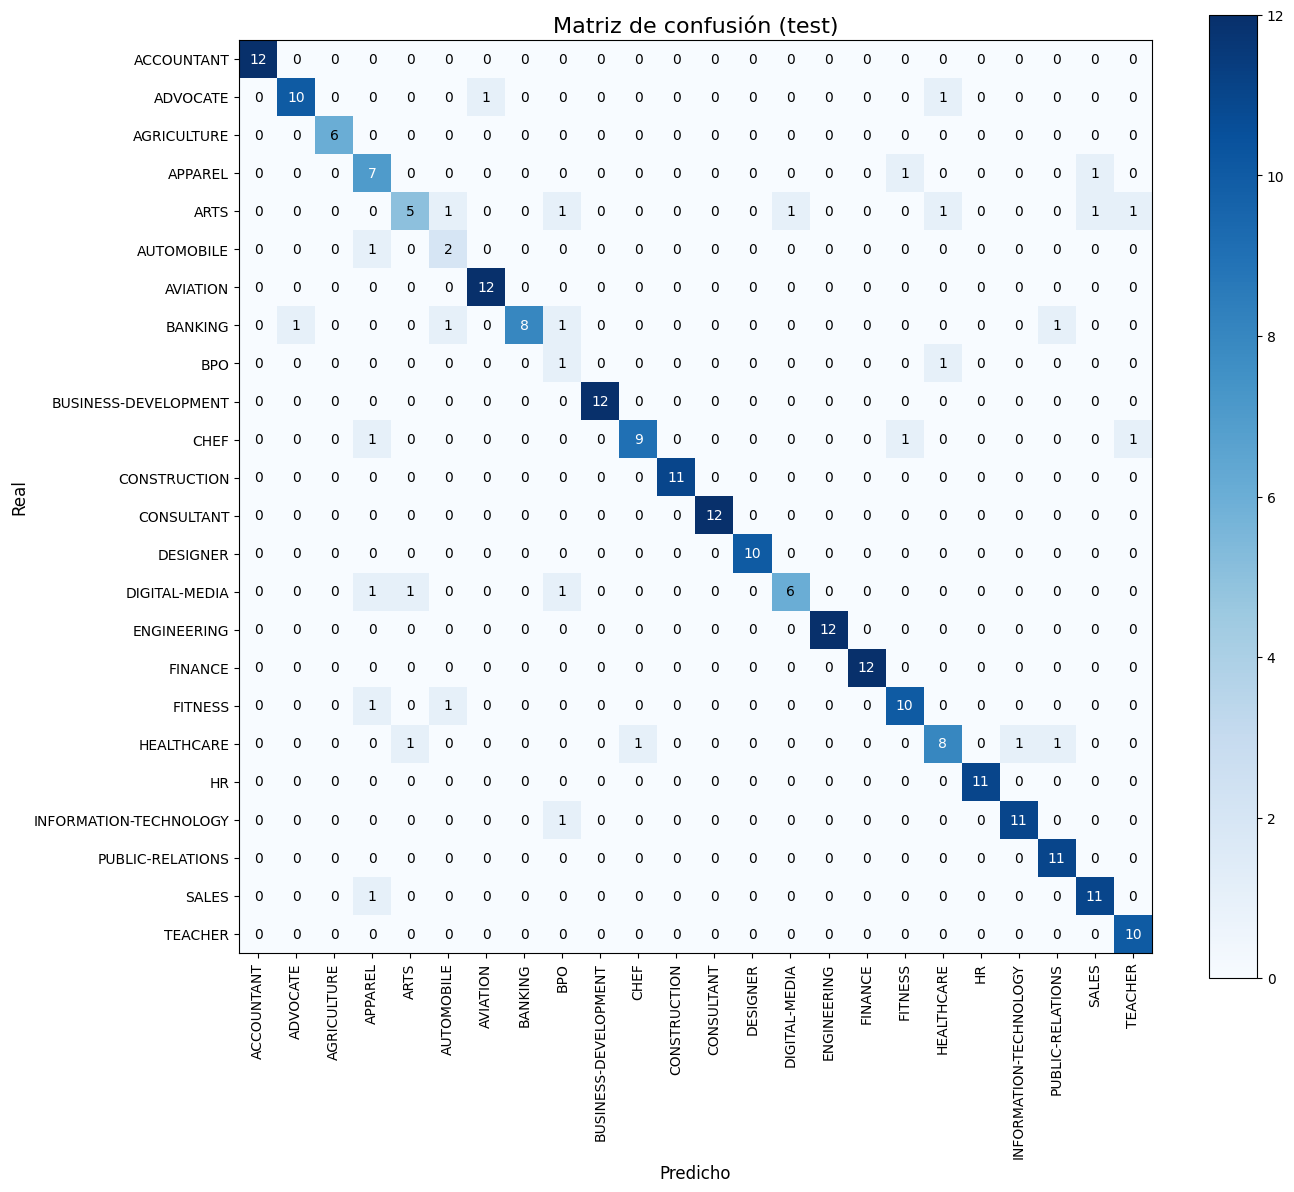

In [18]:
# Matriz de confusión con figura más grande y anotaciones
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(14, 12))  # ajustar tamaño aquí
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_title("Matriz de confusión (test)", fontsize=16)
ticks = np.arange(len(id2label))
labels = [id2label[i] for i in ticks]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels, rotation=90, fontsize=10)
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel("Predicho", fontsize=12)
ax.set_ylabel("Real", fontsize=12)

# Añadir los números en cada celda
fmt = "d"
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black", fontsize=10)

plt.tight_layout()
plt.show()


La matriz de confusión es buena en general: la diagonal domina, señal de que el modelo acierta la mayoría de los casos por clase. Las confusiones aparecen sobre todo entre categorías parecidas o con vocabulario compartido (p. ej., Business-Development ↔ Sales, Information-Technology ↔ Engineering, Digital-Media ↔ Designer, HR/Public-Relations), y en clases con pocos ejemplos (BPO, Automobile, Agriculture), donde la dispersión es mayor.

In [19]:
from sklearn.metrics import roc_auc_score

try:
    roc_macro_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
    print("ROC-AUC macro (OvR) en test:", round(float(roc_macro_ovr), 4))
except Exception as e:
    print("ROC-AUC no disponible:", e)


ROC-AUC macro (OvR) en test: 0.9832


In [20]:
import os
best_ckpt = trainer.state.best_model_checkpoint
print("Best checkpoint:", best_ckpt)

SAVE_DIR = os.path.join(OUTPUT_DIR, "best")
if best_ckpt is not None:
    model.save_pretrained(SAVE_DIR)
    tokenizer.save_pretrained(SAVE_DIR)
    print("Guardado en:", SAVE_DIR)

# Recarga (en otro notebook o más tarde):
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR)
# tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)


Best checkpoint: C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2\results_distilbert\checkpoint-1000
Guardado en: C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2\results_distilbert\best


In [21]:
def predict_texts(text_list, max_len=256):
    enc = tokenizer(
        text_list, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt"
    )
    enc = {k: v.to(model.device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        pred = prob.argmax(axis=1)
    labels = [id2label[i] for i in pred]
    return labels, prob

# Ejemplo:
labels, prob = predict_texts(["Experienced data scientist with NLP background."])
labels[0], prob[0].max()


('INFORMATION-TECHNOLOGY', 0.12550348)

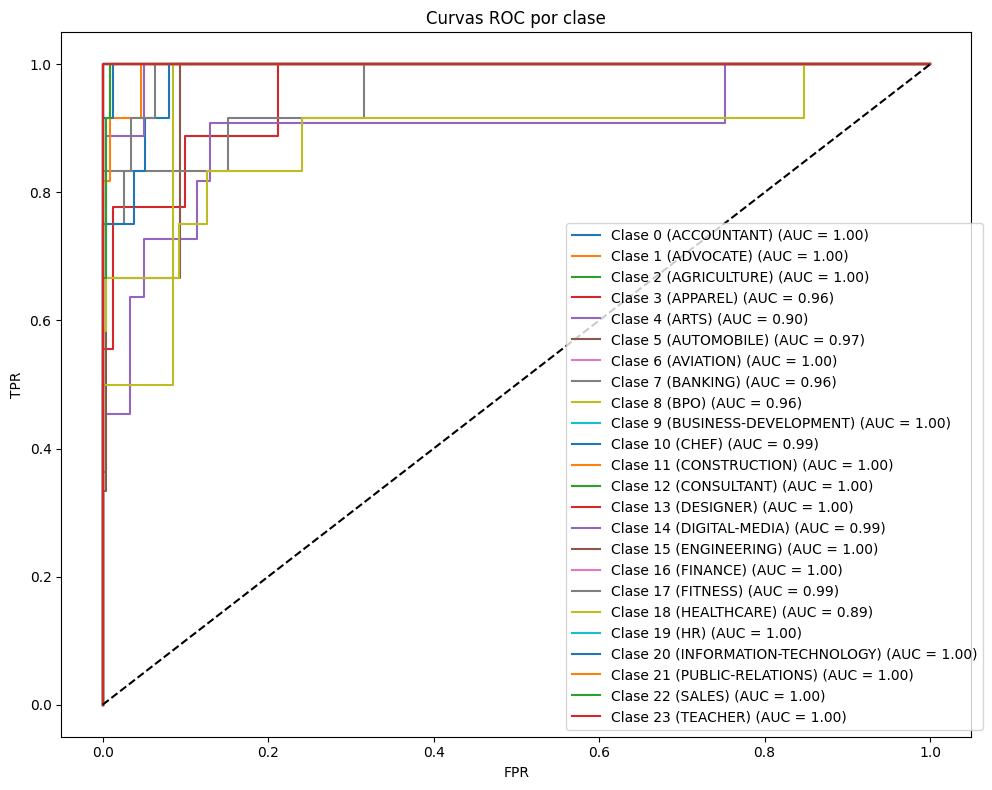

In [22]:
# 8. Curva ROC
# Import only the missing utilities
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy.special import softmax as _softmax  # fallback if probs not precomputed

# Prefer precomputed probabilities (y_prob). If not available, compute from pred_test.predictions logits.
if "y_prob" in globals():
    probs = y_prob
elif "pred_test" in globals():
    probs = _softmax(pred_test.predictions, axis=1)
else:
    raise RuntimeError("No probability predictions found: ensure 'y_prob' or 'pred_test' is available.")

# y_true must be the ground-truth integer labels
if "y_true" not in globals():
    raise RuntimeError("No true labels found: variable 'y_true' is required.")

labels_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} ({id2label.get(i,"")}) (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right', bbox_to_anchor=(1.02, 0))
plt.tight_layout()
plt.show()

Las curvas ROC por clase están muy arriba y pegadas al eje izquierdo, con AUC≈1.0 en la mayoría de categorías y ~0.90–0.97 en unas pocas (p. ej., ARTS, HEALTHCARE), lo que indica que el modelo ordena bien los ejemplos correctos por puntaje aunque luego, al fijar un umbral, aún veamos errores en la matriz de confusión.

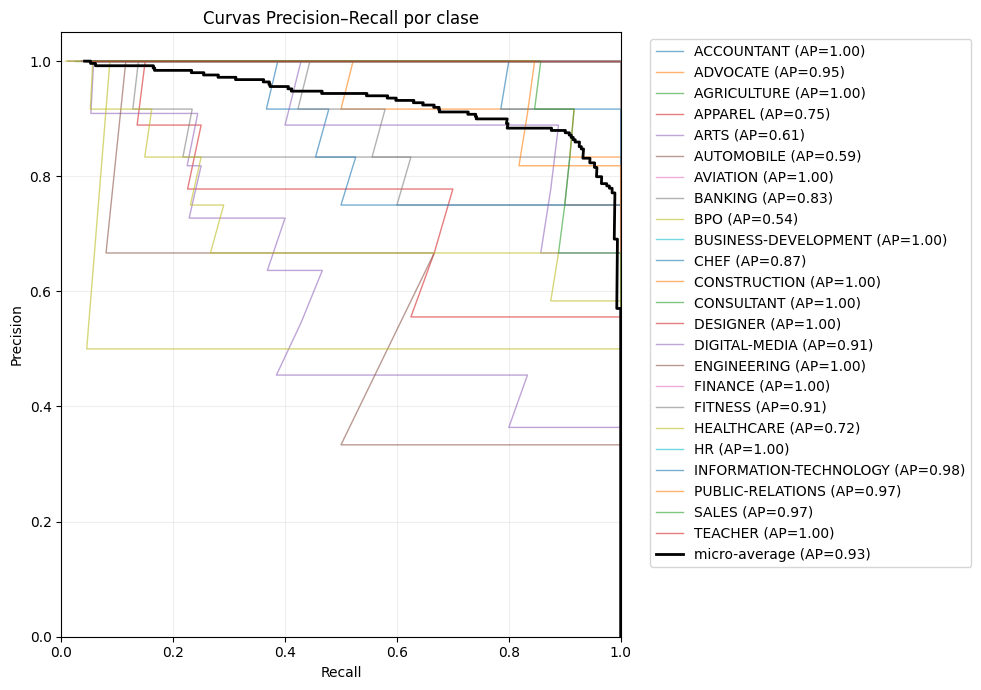

{'AP_micro': 0.9330656459853133, 'AP_macro': 0.9004278526810682}


In [23]:
import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1) Predicciones en test
pred = trainer.predict(test_dataset_hf)  # usa tu Dataset de test
logits = pred.predictions[0] if isinstance(pred.predictions, (list, tuple)) else pred.predictions
y_true = pred.label_ids
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()

# 2) Binariza etiquetas (one-vs-rest)
y_true_bin = np.eye(NUM_CLASSES)[y_true]

# 3) Curvas PR y Average Precision por clase
prec, rec, ap = {}, {}, {}
for c in range(NUM_CLASSES):
    rec[c], prec[c], _ = precision_recall_curve(y_true_bin[:, c], probs[:, c])
    ap[c] = average_precision_score(y_true_bin[:, c], probs[:, c])

# 4) Micro y Macro AP
rec["micro"], prec["micro"], _ = precision_recall_curve(y_true_bin.ravel(), probs.ravel())
ap["micro"]  = average_precision_score(y_true_bin, probs, average="micro")
ap["macro"]  = average_precision_score(y_true_bin, probs, average="macro")

# 5) Plot
plt.figure(figsize=(10, 7))
for c in range(NUM_CLASSES):
    plt.plot(rec[c], prec[c], lw=1, alpha=0.6, label=f"{id2label[c]} (AP={ap[c]:.2f})")
plt.plot(rec["micro"], prec["micro"], color="black", lw=2, label=f"micro-average (AP={ap['micro']:.2f})")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Curvas Precision–Recall por clase")
plt.xlim(0, 1); plt.ylim(0, 1.05)
plt.grid(True, alpha=0.2)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

print({"AP_micro": ap["micro"], "AP_macro": ap["macro"]})


Las curvas PR confirman buen rendimiento global: el AP micro ≈ 0.93 y varias clases tienen AP≈1.00 (p. ej., Accountant, Agriculture, Aviation, Construction, Consultant, Designer, Engineering, Finance, HR, IT, Teacher), lo que indica que el modelo mantiene alta precisión al aumentar el recall. Las más flojas son BPO (0.54), Automobile (0.59), Arts (0.61), Healthcare (0.72), Apparel (0.75) y, en menor medida, Banking (0.83). En resumen: el modelo separa bien la mayoría de categorías, pero pierde calidad en las minoritarias o con vocabulario más genérico.

In [ ]:
if "y_true" in globals() and "y_pred" in globals():
	errores = np.sum(y_true != y_pred)
	total = len(y_true)
	accuracy = (total - errores) / total

	print("=" * 60)
	print(" RESUMEN DE ERRORES - DistilBERT")
	print("=" * 60)
	print(f" Predicciones correctas: {total - errores}")
	print(f" Predicciones incorrectas: {errores}")
	print(f" Total de ejemplos: {total}")
	print(f" Accuracy: {accuracy * 100:.2f}%")
	print(f" Tasa de error: {(errores / total) * 100:.2f}%")
	print("=" * 60)

	# Imprimir classification report si está disponible
	try:
		print("\nClassification report:\n")
		print(classification_report(y_true, y_pred,
									target_names=[id2label[i] for i in range(NUM_CLASSES)],
									digits=4))
	except Exception as e:
		print("No se pudo generar el classification_report:", e)
else:
	raise RuntimeError("Variables 'y_true' y 'y_pred' no encontradas. Ejecuta la evaluación/predicción antes de este cell.")

 RESUMEN DE ERRORES - DistilBERT
 Predicciones correctas: 217
 Predicciones incorrectas: 32
 Total de ejemplos: 249
 Accuracy: 87.15%
 Tasa de error: 12.85%

Classification report:

                        precision    recall  f1-score   support

            ACCOUNTANT     1.0000    1.0000    1.0000        12
              ADVOCATE     0.9091    0.8333    0.8696        12
           AGRICULTURE     1.0000    1.0000    1.0000         6
               APPAREL     0.7143    0.5556    0.6250         9
                  ARTS     0.4286    0.5455    0.4800        11
            AUTOMOBILE     0.3333    0.6667    0.4444         3
              AVIATION     0.8571    1.0000    0.9231        12
               BANKING     1.0000    0.6667    0.8000        12
                   BPO     0.2000    0.5000    0.2857         2
  BUSINESS-DEVELOPMENT     1.0000    1.0000    1.0000        12
                  CHEF     0.9000    0.7500    0.8182        12
          CONSTRUCTION     1.0000    1.0000    1.